# Projet DM Part 2 : Apprentissage supervisé et non supervisé

In [1]:
import numpy as np
import pandas as pd
import copy as cp
import statistics
import re
import math
import matplotlib.pyplot as plt 
from itertools import combinations
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import matplotlib.pyplot as plt
from  collections import Counter
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
import time
import csv
from sklearn.linear_model import LinearRegression
from datetime import datetime
import random
import plotly.express as px
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

## Pretraitement

In [338]:
dataset1 = np.genfromtxt('Dataset1.csv', delimiter=',', dtype=float, skip_header=1)
header = np.genfromtxt('Dataset1.csv', delimiter=',', dtype=str, max_rows=1)
name_attribut={i:f"{n}" for i,n in enumerate(header)}
print(name_attribut)
pd.DataFrame(dataset1, columns=header)

{0: 'N', 1: 'P', 2: 'K', 3: 'pH', 4: 'EC', 5: 'OC', 6: 'S', 7: 'Zn', 8: 'Fe', 9: 'Cu', 10: 'Mn', 11: 'B', 12: 'OM', 13: 'Fertility'}


,N,P,K,pH,EC,OC,S,Zn,Fe,Cu,Mn,B,OM,Fertility
0,138.0,8.6,560.0,7.46,0.62,0.70,5.90,0.24,0.31,0.77,8.71,0.11,1.2040,0.0
1,213.0,7.5,338.0,7.62,0.75,1.06,25.40,0.30,0.86,1.54,2.89,2.29,1.8232,0.0
2,163.0,9.6,718.0,7.59,0.51,1.11,14.30,0.30,0.86,1.57,2.70,2.03,1.9092,0.0
3,157.0,6.8,475.0,7.64,0.58,0.94,26.00,0.34,0.54,1.53,2.65,1.82,1.6168,0.0
4,270.0,9.9,444.0,7.63,0.40,0.86,11.80,0.25,0.76,1.69,2.43,2.26,1.4792,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,276.0,9.2,370.0,7.62,0.62,0.49,6.64,0.42,3.57,0.63,6.48,0.32,0.8428,1.0
881,320.0,13.8,391.0,7.38,0.65,1.07,5.43,0.58,4.58,1.02,13.25,0.53,1.8404,2.0
882,264.0,10.3,475.0,7.49,0.74,0.88,10.56,0.45,7.36,1.87,10.63,0.63,1.5136,0.0
883,220.0,8.6,444.0,7.43,0.65,0.72,11.70,0.37,0.66,0.90,2.19,1.82,1.2384,0.0


In [339]:
def calcul_mediane(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    liste = cp.deepcopy(datasetCurrated)
    liste.sort()
    if liste.size % 2 !=0 :
      
        mediane=liste[((liste.size+1)//2) -1]
    else :
        mediane=(liste[(liste.size//2)-1]+liste[liste.size//2])/2
    return mediane
def val_manquante(attribut):
    L=[]
    for i in range(0,len(dataset1[:,attribut])):
        if not re.fullmatch(r"\d+\.(:?\d+)?", str(dataset1[i, attribut])):
            L.append(i)
    return L
def tendance_centrales_homeMade(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    moyenne2= datasetCurrated.sum() / datasetCurrated.shape[0]
    mediane2=calcul_mediane(attribut)
    unique_values, counts = np.unique(datasetCurrated, return_counts=True)
    Indicemax=np.where(counts == max(counts))[0]
    mode2=[unique_values[i] for i in Indicemax]

    return [moyenne2,mediane2,mode2]
def quartilles_homeMade(attribut):
    datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
    liste = cp.deepcopy(datasetCurrated)
    liste.sort()
    q0=liste[0]
    q1=(liste[liste.size//4-1]+liste[liste.size//4]) /2
    q3=(liste[liste.size*3//4-1]+liste[liste.size*3//4]) /2
    q2=calcul_mediane(attribut)
    q4=liste[-1]
    return [q0,q1,q2,q3,q4]
def ecart_type_home_made(attribut):
     datasetCurrated=np.delete( dataset1[:,attribut], val_manquante(attribut))
     mean = np.mean(datasetCurrated)
     ecarts = [(val - mean) ** 2 for val in datasetCurrated]
     variance = np.mean(ecarts) 
     return np.sqrt(variance)
    

In [340]:
def DiscretisationA(attribut):
    global dataset1
    vals=dataset1[:,attribut].copy()
    vals.sort()
    q = 1+(10/3)*np.log10(dataset1.shape[0])
    nbrelmt=math.ceil(dataset1[:,attribut].shape[0]/q)
    
    for  val in range(0,dataset1[:,attribut].shape[0]):  
        for i in range(0,vals.shape[0],nbrelmt):
            if(vals[i]>dataset1[val,attribut]):
                sup=i
                break
        dataset1[val,attribut]=np.median(vals[sup-nbrelmt:sup])  

In [341]:
# a.Choix de la méthode de remplacement des valeurs manquantes.
def remplacement_val_manquantes(methode,attribut):
    global dataset1
    missing=val_manquante(attribut)
    for i in missing:
        if methode==0:
            dataset1[i,attribut]= statistics.mode(dataset1[:,attribut])    
        else:
            dataset1[i,attribut]= np.mean([dataset1[j,attribut] for j in range(0,len(dataset1)) if dataset1[j,-1]==dataset1[i,-1] and not j in missing])

# b.Choix de la méthode de traitement des valeurs aberrantes
def remplacement_val_aberrantes(methode,attribut):
    global dataset1
    abberante=[]
    if methode==0:
        IQR=(quartilles_homeMade(attribut)[-2]-quartilles_homeMade(attribut)[1])*1.5
        for i in range(0,len(dataset1[:,attribut])):
            if (dataset1[i,attribut] >(quartilles_homeMade(attribut)[-2]+IQR) or dataset1[i,attribut]<(quartilles_homeMade(attribut)[1]-IQR)):
                abberante.append(i)
        X = np.delete(dataset1, attribut, axis=1)
        X = np.delete(X, abberante, axis=0)
        y=dataset1[:,attribut]
        y= np.delete(y, abberante, axis=0).reshape(-1, 1)

        model = LinearRegression().fit(X, y)
         
        for i in abberante:
            x2=np.delete(dataset1, attribut, axis=1)
            X_new =x2[i,:].T.reshape(1, -1)
            dataset1[i,attribut]=model.predict(X_new)[0][0]
    else:
         DiscretisationA(attribut)

def remplacement_manquant_generale(methode):
    for i in range(0,dataset1.shape[1]-1):
        remplacement_val_manquantes(methode,i) 

def remplacement_aberantes_generale(methode):
    for i in range(0,dataset1.shape[1]-1):
        remplacement_val_aberrantes(methode,i)   

In [342]:
def reduire_row():
     global dataset1
     print(len(dataset1))
     dataset1= np.unique(dataset1, axis=0, return_index=False)
     print(len(dataset1))
def coef_correl(attribut1,attribut2):
    moy1=np.mean(dataset1[:,attribut1])
    moy2=np.mean(dataset1[:,attribut2])
    e1=ecart_type_home_made(attribut1)
    e2=ecart_type_home_made(attribut2)
    return (dataset1[:,attribut1].dot(dataset1[:,attribut2])-(len(dataset1)*moy1*moy2))/((len(dataset1)-1)*(e1*e2))
def reduire_dim(treashold):
    global dataset1
    to_delete=[]
    for i in range(0,dataset1.shape[1]-1):
        for j in range(i+1,dataset1.shape[1]):
            if (np.abs(coef_correl(i,j))>treashold):
                print(i,j)
                to_delete.append(i)
    dataset1 = np.delete(dataset1,to_delete, axis=1)


In [343]:
def normalisation(methode,attribut):
    global dataset1
    if methode:
        vmin = 0
        vmax= 1
        vminOld=dataset1[:,attribut].min()
        vmaxOld=dataset1[:,attribut].max()
        for  val in range(0,dataset1[:,attribut].shape[0]):
            dataset1[val,attribut]=vmin+(vmax-vmin)*((dataset1[val,attribut]-vminOld)/(vmaxOld-vminOld))
    else:
        vmean=np.mean(dataset1[:,attribut])
        s=np.mean( (dataset1[:,attribut]  -vmean)**2)
        for  val in range(0,dataset1[:,attribut].shape[0]):
            dataset1[val,attribut]=(dataset1[val,attribut]-vmean)/s 
   
def normalisation_generale(methode):
    for i in range(0,dataset1.shape[1]-1):
        normalisation(methode,i)

In [344]:
remplacement_manquant_generale(1)
remplacement_aberantes_generale(0)   
reduire_row()
reduire_dim(0.75)
normalisation_generale(1)

885
882
5 12


## Metriques de distance

In [345]:
def distance(instance1, instance2, methode):
    if methode==0: # Cosine
         return  1-((np.sum([instance1[i]*instance2[i] for i in range(0,len(instance1))])) / (math.sqrt(np.sum([i**2 for i in instance1]))*math.sqrt(np.sum([i**2 for i in instance2]))))
    else: # Minkowski
        return sum( np.abs(instance1-instance2)**methode)**(1/methode)

## Metriques d'évaluation

In [414]:
def matriceConfusion(y_test, y_pred):
    N = len(np.unique(y_test)) 
    M= np.zeros((N,N),dtype=int)
    for i in range(0,y_test.shape[0]) : 
        M[int(y_test[i])][int(y_pred[i])] += 1    
    return M

def Values(m):
    TP= m.diagonal()
    FP = m.sum(axis=0) - TP
    FN = m.sum(axis=1) - TP
    TN =  m.sum() - (TP + FN + FP)
    return TP, FN, FP, TN

def recall_score(TP, FN):
    return TP/(TP+FN)

def precision_score(TP, FP):
    return TP/(TP+FP)

def tauxFP(FP, TN):
    return  FP/(FP+TN)

def specificity_score(TN, FP):
    return TN/(TN+FP)

def Accuracy_score(M):
    return np.sum(M.diagonal())/np.sum(M)

def f1_score(TP, FP, FN):
    recall = recall_score(TP, FN)
    precision = precision_score(TP, FP)

    if np.any(np.isnan(recall)) or np.any(np.isnan(precision)) or np.all(recall + precision == 0):
        f1 = 0.0  # Handle division by zero or NaN values
    else:
        f1 = 2 * (recall * precision) / (recall + precision)

    return f1

In [415]:
def classification_metrics(Y_test , y_pred):
    M=matriceConfusion(Y_test, y_pred)
    TP, FN, FP, TN=Values(M)
    print(f"accuracy global {np.mean(Accuracy_score(M))}")
    print(f"recall global {np.mean(recall_score(TP, FN))}")
    print(f"precision global {np.mean(precision_score(TP,FP))}")
    print(f"specificité global {np.mean(specificity_score(TN,FP))}")
    print(f"f1 score gloabl {np.mean(f1_score(TP,FP,FN))}")

    print(f"recall {recall_score(TP, FN)}")
    print(f"precision {precision_score(TP,FP)}")
    print(f"taux fp {tauxFP(FP, TN)}")
    print(f"specificité {specificity_score(TN,FP)}")
    print(f"f1 score {f1_score(TP,FP,FN)}")
    
    sns.heatmap(M, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

## 1. Analyse supervisée

In [392]:

def train_test_split(X, y, test_size=0.2, random_state=None):
    if random_state is not None:
        random.seed(random_state)

    data = list(zip(X, y))
    random.shuffle(data)

    split_index = int(len(data) * (1 - test_size))

    train_data = data[:split_index]
    test_data = data[split_index:]

    X_train, y_train = zip(*train_data)
    X_test, y_test = zip(*test_data)

    X_train, X_test, y_train, y_test = np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

    return X_train, X_test, y_train, y_test

# Example usage:
X_train, X_test, Y_train, Y_test = train_test_split(dataset1[:, :-1], dataset1[:, -1], test_size=0.2, random_state=42)

### KNN

In [349]:
import statistics

class KNN:
    def __init__(self, k, methode) -> None:
        self.k = k
        self.methode = methode

    def fit(self, xt, yt):
        self.Xtrain = xt
        self.Ytrain = yt

    def _predict(self, Xtest):
        
        # Calculate Distances
        dist = np.apply_along_axis(lambda x: distance(x, Xtest, self.methode), axis=1, arr=self.Xtrain)

        # Sort Distances
        ind = np.argsort(dist)

        # Select K Nearest Neighbors
        knn = self.Ytrain[ind[:self.k]]

        # Majority Voting
        Y = statistics.mode(knn)
        
        return Y

In [350]:
knnClassifier = KNN(3,2)
knnClassifier.fit(X_train, Y_train)
y_pred=[]
for i in X_test:
    y_pred.append(knnClassifier._predict(i))

accuracy global 0.8418079096045198
recall global 0.6293730424165207
TP FP [70 78  1] [10 14  4]
precision global 0.6409420289855072
specificité global 0.9035848682907507
TP FP [70 78  1] [10 14  4]
TP FP [70 78  1] [10 14  4]
TP FP [70 78  1] [10 14  4]
f1 score gloabl 0.633522900996759
recall [0.8974359  0.84782609 0.14285714]
TP FP [70 78  1] [10 14  4]
precision [0.875      0.84782609 0.2       ]
taux fp [0.1010101  0.16470588 0.02352941]
specificité [0.8989899  0.83529412 0.97647059]
TP FP [70 78  1] [10 14  4]
TP FP [70 78  1] [10 14  4]
TP FP [70 78  1] [10 14  4]
f1 score [0.88607595 0.84782609 0.16666667]


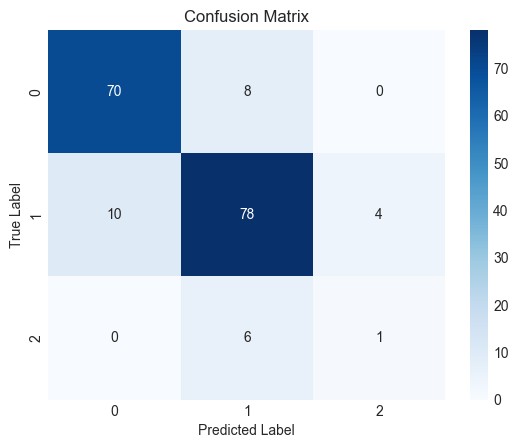

In [351]:
classification_metrics(Y_test, y_pred)

### Decision Trees

In [352]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
        #desicion node
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.info_gain = info_gain
        # leaf node
        self.value = value

In [411]:
class DtClassifier():
    def __init__(self, min_samples_split, max_depth, info_gain_method, n_features=None):
        self.root = None
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.n_features = n_features
        self.info_gain_method = info_gain_method

    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:, :-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)

        # Pre-pruning
        if num_samples < self.min_samples_split or curr_depth == self.max_depth:
            leaf_value = self.calculate_leaf_value(Y)
            return Node(value=leaf_value)

        # find the best split
        best_split = self.get_best_split(dataset, num_samples, num_features)

        # Pre-pruning
        if best_split is None or "info_gain" not in best_split or best_split["info_gain"] <= 0:
            leaf_value = self.calculate_leaf_value(Y)
            return Node(value=leaf_value)


        left_subtree = self.build_tree(best_split["dataset_left"], curr_depth + 1)
        right_subtree = self.build_tree(best_split["dataset_right"], curr_depth + 1)

        # Post-pruning
        current_info_gain = best_split["info_gain"]
        leaf_info_gain = self.information_gain(Y, None, None, self.info_gain_method)
        if leaf_info_gain >= current_info_gain:
            leaf_value = self.calculate_leaf_value(Y)
            return Node(value=leaf_value)

        return Node(
            best_split["feature_index"],
            best_split["threshold"],
            left_subtree,
            right_subtree,
            best_split["info_gain"]
        )
    
    def get_best_split(self, dataset, num_samples, num_features):
    
        best_split = {}
        max_info_gain = -float("inf")
        
        if self.n_features is not None:
            feature_indices = np.random.choice(num_features, self.n_features, replace=False)
        else:
            feature_indices = range(num_features)
        
        for feature_index in feature_indices:
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]

                    curr_info_gain = self.information_gain(y, left_y, right_y, self.info_gain_method)

                    if curr_info_gain > max_info_gain:
                        best_split["feature_index"] = feature_index
                        best_split["threshold"] = threshold
                        best_split["dataset_left"] = dataset_left
                        best_split["dataset_right"] = dataset_right
                        best_split["info_gain"] = curr_info_gain
                        max_info_gain = curr_info_gain
      
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        
        dataset_left = np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index]>threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode):
        if l_child is None or r_child is None:
            return 0

        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)

        if mode == "Gini":
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        else:
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))

        return gain

    
    def entropy(self, y):
        
        class_labels = np.unique(y)
        entropy = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy
    
    def gini_index(self, y):
        
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
        return 1 - gini
        
    def calculate_leaf_value(self, Y):
        unique_classes, counts = np.unique(Y, return_counts=True)
        return unique_classes[np.argmax(counts)]
    
    def fit(self, X, Y):
        if len(Y.shape) == 1:
            Y = Y.reshape(-1, 1)

        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)

    
    def predict(self, X):
        
        preditions = [self.make_prediction(x, self.root) for x in X]
        return preditions
    
    def make_prediction(self, x, tree):
        if tree.value is not None:
            print(f"Reached leaf node: Predicted Value {tree.value}")
            
            return tree.value

        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            print(f"At Node: Feature {tree.feature_index} <= Threshold {tree.threshold}, Move to Left Subtree")
            
            return self.make_prediction(x, tree.left)
        else:
            print(f"At Node: Feature {tree.feature_index} > Threshold {tree.threshold}, Move to Right Subtree")
            
            return self.make_prediction(x, tree.right)
        

In [412]:
DTClassifier = DtClassifier(min_samples_split=2, max_depth=5, info_gain_method="Gini")
DTClassifier.fit(X_train, Y_train)
y_pred = DTClassifier.predict(X_test) 
prediction = DTClassifier.predict(np.array([[0.01801802, 0.36641221, 0.3627451, 0.33027523, 0.62666667, 0.74576271, 0.11841283, 0.07156673, 0.39303483, 0.1322228, 0.27280741, 0.03066867]]))

At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 1 > Threshold 0.5954198473282442, Move to Right Subtree
At Node: Feature 0 <= Threshold 0.7717717717717718, Move to Left Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 1 <= Threshold 0.5954198473282442, Move to Left Subtree
At Node: Feature 0 > Threshold 0.6426426426426426, Move to Right Subtree
At Node: Feature 8 > Threshold 0.08955223880597014, Move to Right Subtree
At Node: Feature 1 > Threshold 0.1603053435114504, Move to Right Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 <= Threshold 0.6216216216216216, Move to Left Subtree
At Node: Feature 1 <= Threshold 0.48091603053435106, Move to Left Subtree
At Node: Feature 7 > Threshold 0.02514506769825919, Move to Right Subtree
At Node: Feature 0 <= Threshold 0.5645645645645646, Move to Left Subtree
At Node: Feature 9 > Threshold 0.1170323928

Parameters used by DecisionTreeClassifier:
Criterion: gini
Splitter: best
Max Depth: 5
Min Samples Split: 2
Min Samples Leaf: 1
Precision for Class 0: 0.9375
Precision for Class 1: 0.9139784946236559
Precision for Class 2: 0.5
Accuracy:0.9152542372881356


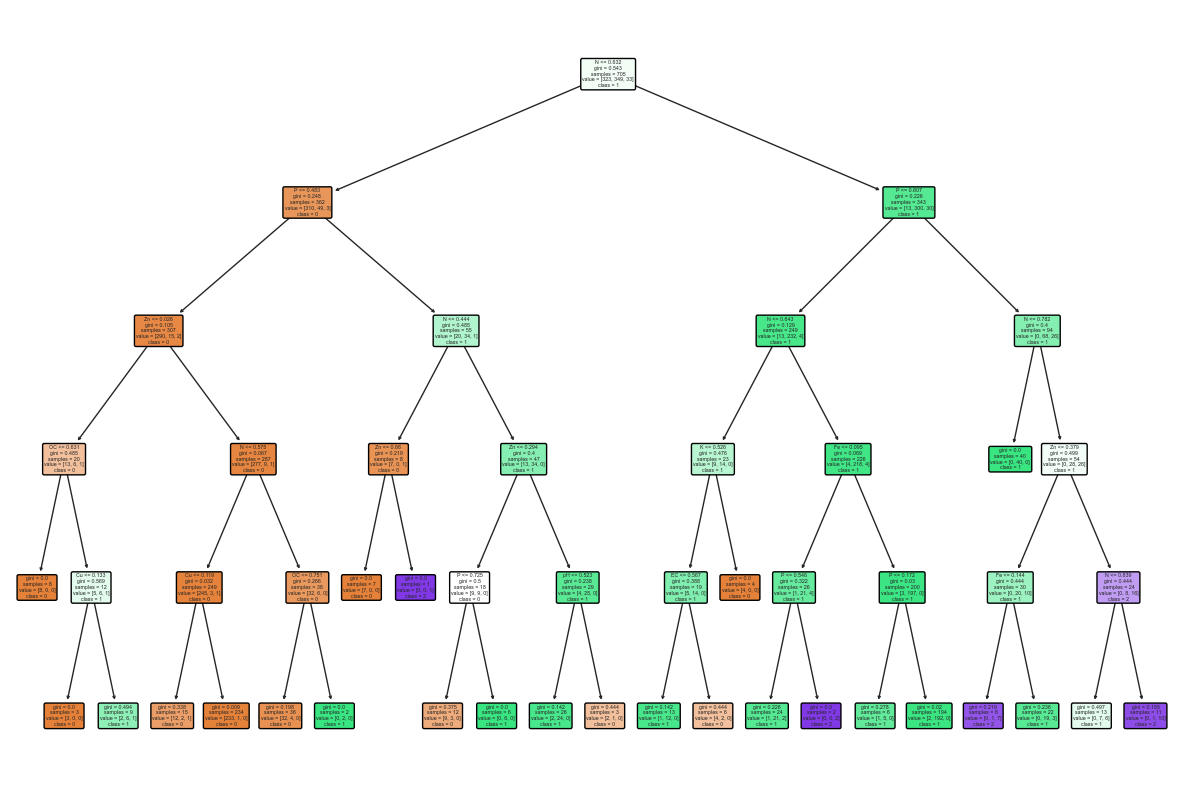

In [410]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, accuracy_score

DTClassifier = DecisionTreeClassifier(criterion='gini', max_depth=5, random_state=42)
DTClassifier.fit(X_train, Y_train)
pred = DTClassifier.predict(X_test)

precision_per_class = precision_score(Y_test, pred, average=None)
accuracy = accuracy_score(Y_test, pred)
print("Parameters used by DecisionTreeClassifier:")
print(f"Criterion: {DTClassifier.criterion}")
print(f"Splitter: {DTClassifier.splitter}")
print(f"Max Depth: {DTClassifier.max_depth}")
print(f"Min Samples Split: {DTClassifier.min_samples_split}")
print(f"Min Samples Leaf: {DTClassifier.min_samples_leaf}")
for class_idx, precision in enumerate(precision_per_class):
    print(f'Precision for Class {class_idx}: {precision}')
print(f'Accuracy:{accuracy}')
    
# Plot the decision tree
plt.figure(figsize=(15, 10))
plot_tree(DTClassifier, feature_names=header[:-1], class_names=[str(int(c)) for c in np.unique(Y_train)], filled=True, rounded=True)
plt.show()


accuracy global 0.903954802259887
recall global 0.6724796942188247
precision global 0.7208283552369573
specificité global 0.94058229352347
f1 score gloabl 0.6838347781744009
recall [0.96153846 0.91304348 0.14285714]
precision [0.92592593 0.90322581 0.33333333]
taux fp [0.06060606 0.10588235 0.01176471]
specificité [0.93939394 0.89411765 0.98823529]
f1 score [0.94339623 0.90810811 0.2       ]


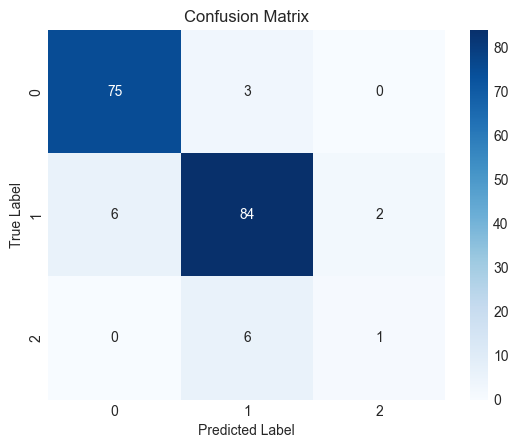

In [416]:
classification_metrics(Y_test, y_pred)

### Random Forest

In [420]:
class RandomForestClassifier:
    def __init__(self, n_trees, max_depth, min_samples_split, n_features, info_gain_method):
        self.n_trees = n_trees
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.trees = []
        self.info_gain_method = info_gain_method

    def fit(self, X, Y):
        for i in range(self.n_trees):
            # Create a sub-dataset randomly
            subset_indices = np.random.choice(len(X), len(X), replace=True)
            subset_X = X[subset_indices, :]
            subset_Y = Y[subset_indices]

            # compute the decision tree of the sub-dataset
            tree = DtClassifier(
                min_samples_split=self.min_samples_split,
                max_depth=self.max_depth,
                info_gain_method=self.info_gain_method,
                n_features=self.n_features
            )
            tree.fit(subset_X, subset_Y)

            self.trees.append(tree) #add it to the forest

    def predict(self, X):
        tree_predictions = [tree.predict(X) for tree in self.trees]

        #predict using majority voting 
        predictions = np.array(tree_predictions).T.astype(int)
        final_predictions = [np.argmax(np.bincount(prediction)) for prediction in predictions]
        # Print predictions for each tree and the final prediction
        for tree_idx, tree_prediction in enumerate(tree_predictions):
            print(f"\nTree {tree_idx + 1} Predictions: {tree_prediction}")

        print(f"\nFinal Predictions: {final_predictions}")

        return final_predictions


In [446]:
random_forest = RandomForestClassifier(n_trees=30, max_depth=6, min_samples_split=2, n_features=6, info_gain_method="Gini")
random_forest.fit(X_train, Y_train)
y_pred = random_forest.predict(X_test)
prediction = random_forest.predict(np.array([[0.01801802, 0.36641221, 0.3627451, 0.33027523, 0.62666667, 0.74576271, 0.11841283, 0.07156673, 0.39303483, 0.1322228, 0.27280741, 0.03066867]]))

At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 0 > Threshold 0.6426426426426426, Move to Right Subtree
At Node: Feature 1 > Threshold 0.5954198473282442, Move to Right Subtree
At Node: Feature 0 <= Threshold 0.7717717717717718, Move to Left Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 > Threshold 0.6216216216216216, Move to Right Subtree
At Node: Feature 0 > Threshold 0.6426426426426426, Move to Right Subtree
At Node: Feature 1 <= Threshold 0.5954198473282442, Move to Left Subtree
At Node: Feature 0 > Threshold 0.6606606606606606, Move to Right Subtree
At Node: Feature 6 > Threshold 0.1184128266724747, Move to Right Subtree
At Node: Feature 7 <= Threshold 0.7495164410058027, Move to Left Subtree
Reached leaf node: Predicted Value 1.0
At Node: Feature 0 <= Threshold 0.6216216216216216, Move to Left Subtree
At Node: Feature 1 <= Threshold 0.48091603053435106, Move to Left Subtree
At Node: Feature 6 > Threshold 0.096210421671

accuracy global 0.9209039548022598
recall global 0.6813983118330945
precision global 0.9517753047164813
specificité global 0.9462071697365815
f1 score gloabl 0.7084011575330078
recall [0.92307692 0.97826087 0.14285714]
precision [0.97297297 0.88235294 1.        ]
taux fp [0.02020202 0.14117647 0.        ]
specificité [0.97979798 0.85882353 1.        ]
f1 score [0.94736842 0.92783505 0.25      ]


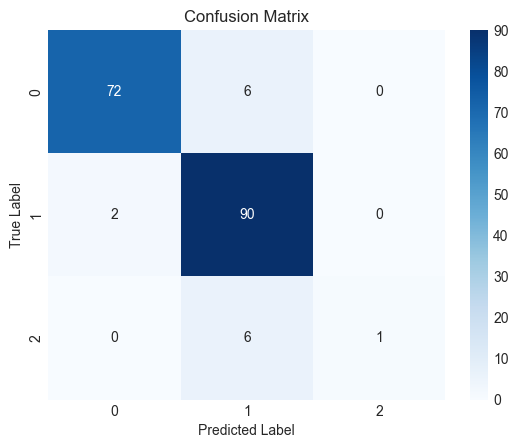

In [447]:
classification_metrics(Y_test, y_pred)

### Comparaison 

In [449]:
import time

num_executions = 10

rf_execution_times = []
dt_execution_times = []
knn_execution_times = []

for _ in range(num_executions):
    # Random Forest
    rf_classifier = RandomForestClassifier(n_trees=30, max_depth=6, min_samples_split=2, n_features=6, info_gain_method="Gini")
    rf_start_time = time.time()
    rf_classifier.fit(X_train, Y_train)
    rf_end_time = time.time()
    rf_execution_times.append(rf_end_time - rf_start_time)

    # Decision Tree
    dt_classifier = DtClassifier(min_samples_split=2, max_depth=5, info_gain_method="Gini")
    dt_start_time = time.time()
    dt_classifier.fit(X_train, Y_train)
    dt_end_time = time.time()
    dt_execution_times.append(dt_end_time - dt_start_time)

    # K-Nearest Neighbors
    knn_classifier = KNN(3,2)
    knn_start_time = time.time()
    knn_classifier.fit(X_train, Y_train)
    knn_end_time = time.time()
    knn_execution_times.append(knn_end_time - knn_start_time)

# Calculate mean execution times
rf_mean_time = np.mean(rf_execution_times)
dt_mean_time = np.mean(dt_execution_times)
knn_mean_time = np.mean(knn_execution_times)


print(f"Random Forest Mean Execution Time: {rf_mean_time} seconds")
print(f"Decision Tree Mean Execution Time: {dt_mean_time} seconds")
print(f"K-Nearest Neighbors Mean Execution Time: {knn_mean_time} seconds")


Random Forest Mean Execution Time: 168.98211574554443 seconds
Decision Tree Mean Execution Time: 10.995086622238158 seconds
K-Nearest Neighbors Mean Execution Time: 0.0 seconds


### Tuning

In [361]:
accuracy_scores = []
for K in np.arange(2,10,1):
        try:
            knnClassifier = KNN(K,2)
            knnClassifier.fit(X_train, Y_train)
            y_pred=[]
            for i in X_test:
                y_pred.append(knnClassifier._predict(i))
            M = confusion_matrix(Y_test, y_pred)
            accuracy_scores.append(Accuracy_score(M))
        except Exception as e:
            pass
print(accuracy_scores)

[0.7966101694915254, 0.8418079096045198, 0.847457627118644, 0.8587570621468926, 0.847457627118644, 0.8248587570621468, 0.8248587570621468, 0.8248587570621468]


In [407]:
max_depth_values = [None, 5, 8, 10, 12]
min_samples_split_values = [2, 3, 4, 5, 6]

best_accuracy = 0
best_params = {}

# Loop through hyperparameter values
for max_depth in max_depth_values:
        for min_samples_split in min_samples_split_values:
                # Create and train the model
                dt_classifier = DtClassifier(
                    info_gain_method='Gini',
                    max_depth=max_depth,
                    min_samples_split=min_samples_split
                )
                dt_classifier.fit(X_train, Y_train)

                # Make predictions on the test set
                y_pred = dt_classifier.predict(X_test)

                # Evaluate accuracy
                accuracy = accuracy_score(Y_test, y_pred)
                print(max_depth, min_samples_split, accuracy)
                # Check if this set of hyperparameters gives a better accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                    }

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_params)
print("Best Test Accuracy:", best_accuracy)

None 2 0.8700564971751412
None 3 0.8700564971751412
None 4 0.8757062146892656
None 5 0.8757062146892656
None 6 0.8700564971751412
5 2 0.903954802259887
5 3 0.903954802259887
5 4 0.903954802259887
5 5 0.903954802259887
5 6 0.903954802259887
8 2 0.8700564971751412
8 3 0.8700564971751412
8 4 0.8757062146892656
8 5 0.8757062146892656
8 6 0.8700564971751412
10 2 0.8700564971751412
10 3 0.8700564971751412
10 4 0.8757062146892656
10 5 0.8757062146892656
10 6 0.8700564971751412
12 2 0.8700564971751412
12 3 0.8700564971751412
12 4 0.8757062146892656
12 5 0.8757062146892656
12 6 0.8700564971751412
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 2}
Best Test Accuracy: 0.903954802259887


In [ ]:
max_depth_values = [2, 4, 6]
min_samples_split_values = [2, 4, 6]
n_trees_values = [20, 50, 70]
n_features_values = [2, 4, 6, 12]

best_accuracy = 0
best_params = {}

# Loop through hyperparameter values
for max_depth in max_depth_values:
    for n_features in n_features_values:
        for min_samples_split in min_samples_split_values:
            for n_trees in n_trees_values:
                # Create and train the model
                rf_classifier = RandomForestClassifier(
                    info_gain_method='Gini',
                    max_depth=max_depth,
                    min_samples_split=min_samples_split,
                    n_features=n_features,
                    n_trees=n_trees
                )
                rf_classifier.fit(X_train, Y_train)

                # Make predictions on the test set
                y_pred = rf_classifier.predict(X_test)

                # Evaluate accuracy
                accuracy = accuracy_score(Y_test, y_pred)
                print(max_depth, n_features, min_samples_split, n_trees, accuracy)
                # Check if this set of hyperparameters gives a better accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_params = {
                        'max_depth': max_depth,
                        'min_samples_split': min_samples_split,
                        'n_trees': n_trees,
                        'n_features': n_features
                    }

# Print the best hyperparameters and accuracy
print("Best Hyperparameters:", best_params)
print("Best Test Accuracy:", best_accuracy)

## 2. Analyse non supervisée

In [ ]:
dataset1=dataset1[:,:-1]

### K means

In [ ]:
class K_MEANS:
    def __init__(self,k,methode_d,methode_c,max_iterations) -> None:
        self.k = k
        self.centroid=[]
        self.dataset_letiqu = np.hstack((dataset1.copy(), -1*np.ones((dataset1.shape[0], 1))))
        self.methode_c=methode_c
        self.methode_d=methode_d
        self.max_iterations=max_iterations
    def fit(self,xt):
        self.Xtrain=xt
    def centroid_selection(self,methode):
        if methode==0:#random sans prendre le meme
            self.centroid.extend(self.Xtrain[random.sample(range(self.Xtrain.shape[0]), self.k),:])   
        elif methode==1:#better picking
            self.centroid.append(list(self.Xtrain[np.random.choice(self.Xtrain.shape[0]),:]))
            dist =  np.apply_along_axis(lambda x: distance(x, self.centroid[0], self.methode_d), axis=1, arr=self.Xtrain)
            ind = np.argsort(dist)
            for i in range(self.k,0,-1):
                self.centroid.append(list(self.Xtrain[ind[int((len(ind)/self.k)*i )-1],:]))
    
    def _cluster(self):#instance
        #choose centroid 
        self.centroid_selection(self.methode_c)  
        #boucle
        change=True
        nbr_iteration=0
        while(change):
        #distance
            for j in range(self.Xtrain.shape[0]):
                distances=[]
                for i in range(self.k):
                    distances.append(distance(instance1= self.centroid[i], instance2= self.Xtrain[j,:] ,methode=self.methode_d))
                #affectation
                c =np.argmin(distances)
                self.dataset_letiqu[j,-1]=c
            #maj centroid
            oldcentroid=self.centroid.copy()
            for i in range(self.k):
                cluster=np.array([row[:-1] for row in self.dataset_letiqu if row[-1]==i])
                self.centroid[i]=np.array([np.average(cluster[:,j]) for j in range(cluster.shape[1])] )

            #print(type(centroid))
            if np.linalg.norm(np.array(self.centroid) - np.array(oldcentroid)) < 0.0001 or nbr_iteration>self.max_iterations:
                change=False
            nbr_iteration+=1
        return self.dataset_letiqu
    #bonus
    def _prediction(self,instance):
        distances=[]
        for i in range(self.k):
            distances.append(distance(self.centroid[i],instance,self.methode_d ))
        return np.argmin(distances),np.array([row[:-1] for row in self.dataset_letiqu if row[-1]==np.argmin(distances)])

- Silhouette


In [ ]:
def silhouette_scorec(data, labels, metric):
    num_points = len(data)
    unique_labels = np.unique(labels)
    silhouette_values = np.zeros(num_points)

    intra_cluster_distances = np.zeros(num_points)
    inter_cluster_distances = np.zeros(num_points)

    for i in range(num_points):
        #ai
        label_i = labels[i]
        cluster_i_indices = np.where(labels == label_i)[0] # get own cluster points
        if len(cluster_i_indices) == 1:
            silhouette_i = 0  # Set silhouette score to 0 for single point clusters
        else:
            a_i = np.mean([distance(data[i],data[j],metric) for j in cluster_i_indices if j != i])
            inter_cluster_distances[i] = a_i

            #bi
            b_i_values = []
            for label_j in unique_labels:
                if label_j != label_i:
                    cluster_j_indices = np.where(labels == label_j)[0] # get neighbor clusters points
                    b_ij = np.mean([distance(data[i], data[j], metric) for j in cluster_j_indices])
                    b_i_values.append(b_ij)
            
            # get the average distance to the nearest neighbor cluster bi
            b_i = min(b_i_values) if b_i_values else 0
            intra_cluster_distances[i] = b_i

            # silhouette score of the point i
            silhouette_i = (b_i - a_i) / max(a_i, b_i)
            
        silhouette_values[i] = silhouette_i
            
    # silhouette score of data
    silhouette_score_avg = np.mean(silhouette_values)
    
    # Calculate overall intra-cluster and inter-cluster distances
    intra_distance = np.sum(intra_cluster_distances)
    inter_distance = np.sum(inter_cluster_distances)

    return silhouette_score_avg, intra_distance, inter_distance


### Experimentations

In [ ]:
kmeans_home_made = K_MEANS(k=3,methode_d=1,methode_c=1,max_iterations=500)
kmeans_home_made.fit(dataset1)
res=kmeans_home_made._cluster()

prediction=kmeans_home_made._prediction([0.05705706 ,0.11450382 ,0.46568627, 0.67889908, 0.44 ,      0.3170904,
0.23682565, 0.36847195, 0.46766169, 0.67607106, 0.17568159,0.44    ])
print(prediction)

silhouette_avg = silhouette_score(dataset1, res[:,-1], metric='cosine')
print("silhouette score predef :", silhouette_avg)

score, intra_dist, inter_dist = silhouette_scorec(dataset1,res[:,-1], 0)
print("Silhouette Score Home made:", score)
print("intra distance = ", intra_dist)
print("inter distance = ", inter_dist)

# Applying k-means clustering
kmeans = KMeans(n_clusters=3,max_iter=300,init='random',tol=0.0001)
kmeans.fit(dataset1[:,:-1])
silhouette_avg = silhouette_score(dataset1,kmeans.labels_, metric='cosine')
print("silhouette score predef :", silhouette_avg)

score, intra_dist, inter_dist = silhouette_scorec(dataset1,kmeans.labels_, 0)
print("Silhouette Score Home made:", score)
print("intra distance = ", intra_dist)
print("inter distance = ", inter_dist)

(2, array([[0.00000000e+00, 3.96946565e-01, 3.79084967e-01, ...,
        3.20794148e-01, 2.12667426e-01, 4.49524120e-02],
       [0.00000000e+00, 4.35114504e-01, 5.17973856e-01, ...,
        4.20062696e-01, 3.69856393e-01, 2.43667280e-02],
       [3.90390390e-02, 2.29007634e-01, 3.79084967e-01, ...,
        4.24764890e-01, 1.10956918e-01, 8.40231999e-04],
       ...,
       [9.60960961e-01, 3.12977099e-01, 6.55228758e-01, ...,
        4.77011494e-01, 2.40406656e-01, 4.91535720e-02],
       [9.60960961e-01, 6.33587786e-01, 7.07516340e-01, ...,
        4.34691745e-01, 8.32176885e-02, 5.88162400e-03],
       [9.81981982e-01, 2.97709924e-01, 1.71568627e-01, ...,
        4.03866249e-01, 6.47248689e-02, 6.72185599e-03]]))
silhouette score predef : 0.13702516577433244
Silhouette Score Home made: 0.13702516577433244
intra distance =  135.25994353458873
inter distance =  114.80265295888097


c:\Users\Asus Zenbook Flip\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


silhouette score predef : 0.20579062783910765
Silhouette Score Home made: 0.2057906278391077
intra distance =  142.63325324708194
inter distance =  110.19424049572781


### DBSCAN

In [ ]:
class Point:
    def __init__(self, instance):
        self.instance=instance
        self.marked=False
        self.cluster=False
        
   
def Voisinage(P,radius,methode_d):
    voisins=[]
    for i in range(dataset1.shape[0]):
        if  distance(dataset1[i,:],P.instance,methode_d) <=radius:
            voisins.append(i)
    return voisins

def DB_Scan(radius,min_points,methode_d):
    C = 0
    Outlier=[]
    dataset_labeled=[]
    listeP=[ Point(instance) for instance in dataset1[:,:]]
    
    for P in listeP:
        if not P.marked:
            P.marked=True
            PtsVoisins = Voisinage(P, radius,methode_d) 
            if len(PtsVoisins) < min_points :
                Outlier.append(P)
                dataset_labeled.append(np.append(P.instance,-1)) 
            else:
                C+=1 #new cluster
                P.instance=np.append(P.instance,C)
                P.cluster=True 
                dataset_labeled.append(P.instance)
                for i in PtsVoisins:
                    if not listeP[i].marked :
                        listeP[i].marked=True
                        v=Voisinage(listeP[i], radius,methode_d)
                        if len(v) >= min_points :
                            PtsVoisins.extend(v) 
                    if (not listeP[i].cluster) : 
                        listeP[i].cluster=True
                        if listeP[i] in Outlier:
                            Outlier.remove(listeP[i])
                            for j in range(len(dataset_labeled)):
                                if  np.array_equal( dataset_labeled[j][:-1],listeP[i].instance):
                                    listeP[i].instance=np.append(listeP[i].instance,C)
                                    dataset_labeled[j][-1]=C 
                                    break                        
                        else: 
                            listeP[i].instance=np.append(listeP[i].instance,C)
                            dataset_labeled.append(listeP[i].instance)
        
    return [list(i[:-1]) for i in dataset_labeled ],[i[-1] for i in dataset_labeled ],([i for i in dataset_labeled if i[-1]==-1])

In [ ]:
# Apply DBSCAN
a=DB_Scan(1.2,5,methode_d=2)
print(a[0])
print(a[1])
silhouette_avg = silhouette_score(np.array(a[0]), a[1], metric='euclidean')
print("silhouette score predef :", silhouette_avg)

score, intra_dist, inter_dist = silhouette_scorec(np.array(a[0]), a[1], 2)
print("Silhouette Score Home made:", score)
print("intra distance :", intra_dist)
print("inter distance :", inter_dist)

#DBSCAN PREDEF
# dbscan = DBSCAN(eps=1.2, min_samples=5)
# labels = dbscan.fit_predict(dataset1)
# silhouette_avg = silhouette_score(dataset1, labels, metric='cosine')
# print("silhouette score predef :", silhouette_avg)

# score = silhouette_scorec(dataset1, labels, 0)
# print("Silhouette Score Home made:", score)

[[0.0, 0.3969465648854961, 0.3790849673202614, 0.5871559633027515, 0.7200000000000001, 0.6793785310734463, 0.19242084334277137, 0.4158607350096712, 0.6019900497512437, 0.32079414838035525, 0.21266742624087126, 0.04495241196549334], [0.0, 0.4122137404580153, 0.4133986928104575, 0.36697247706422026, 0.18666666666666668, 0.7740112994350282, 0.26642886001306804, 0.0367504835589942, 0.3980099502487562, 0.1091954022988506, 0.32659652965897334, 0.030668467976458075], [0.0, 0.43511450381679384, 0.5179738562091504, 0.09174311926605466, 0.25333333333333335, 0.18926553672316382, 0.15541683500762304, 0.2079303675048356, 0.6169154228855721, 0.4200626959247649, 0.3698563934623848, 0.024366727981295456], [0.018018018018018018, 0.282442748091603, 0.29248366013071897, 0.4587155963302749, 0.49333333333333323, 0.5903954802259886, 0.2960320666811867, 0.04158607350096712, 0.5422885572139302, 0.18547544409613376, 0.3187177372904341, 0.03318916397452312], [0.018018018018018018, 0.36641221374045807, 0.3627450